# CNN

## Notebook's Environment

In [1]:
INSTALL_DEPS = False
if INSTALL_DEPS:
  %pip install hurst==0.0.5
  %pip install imbalanced_learn==0.12.3
  %pip install imblearn==0.0
  %pip install protobuf==5.27.0
  %pip install pykalman==0.9.7
  %pip install tqdm==4.66.4

!python --version

Python 3.11.8


## Cloud Environment Setup

In [2]:
import os
import sys
import warnings

warnings.filterwarnings("ignore")

IN_KAGGLE = IN_COLAB = False
try:
    # https://www.tensorflow.org/install/pip#windows-wsl2
    import google.colab
    from google.colab import drive

    drive.mount("/content/drive")
    DATA_PATH = "/content/drive/MyDrive/EDT dataset"
    MODEL_PATH = "/content/drive/MyDrive/models"
    IN_COLAB = True
    print("Colab!")
except:
    IN_COLAB = False
if "KAGGLE_KERNEL_RUN_TYPE" in os.environ and not IN_COLAB:
    print("Running in Kaggle...")
    for dirname, _, filenames in os.walk("/kaggle/input"):
        for filename in filenames:
            print(os.path.join(dirname, filename))
    MODEL_PATH = "./models"
    DATA_PATH = "/kaggle/input/intra-day-agriculture-futures-trades-2023-2024"
    IN_KAGGLE = True
    print("Kaggle!")
elif not IN_COLAB:
    IN_KAGGLE = False
    MODEL_PATH = "./models"
    DATA_PATH = "./data/"
    print("running localhost!")

running localhost!


In [3]:
import tensorflow as tf
from tensorflow.keras import mixed_precision

print(f'Tensorflow version: [{tf.__version__}]')

tf.get_logger().setLevel('INFO')

#tf.config.set_soft_device_placement(True)
#tf.config.experimental.enable_op_determinism()
#tf.random.set_seed(1)
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.TPUStrategy(tpu)
except Exception as e:
  gpus = tf.config.experimental.list_physical_devices('GPU')
  if len(gpus) > 0:
    try:
        strategy = tf.distribute.MirroredStrategy()
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
    finally:
        print("Running on", len(tf.config.list_physical_devices('GPU')), "GPU(s)")
  else:
    # CPU is final fallback
    strategy = tf.distribute.get_strategy()
    print("Running on CPU")

def is_tpu_strategy(strategy):
    return isinstance(strategy, tf.distribute.TPUStrategy)

print("Number of accelerators:", strategy.num_replicas_in_sync)
os.getcwd()

2024-06-01 12:27:57.370025: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-01 12:27:57.443591: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-01 12:27:57.443670: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-01 12:27:57.446950: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-01 12:27:57.475600: I tensorflow/core/platform/cpu_feature_guar

Tensorflow version: [2.15.1]


2024-06-01 12:27:59.575871: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
1 Physical GPUs, 1 Logical GPUs
Physical devices cannot be modified after being initialized
Running on 1 GPU(s)
Number of accelerators: 1


2024-06-01 12:27:59.789294: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-01 12:27:59.789341: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-01 12:27:59.805769: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-01 12:27:59.805821: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-01 12:27:59.805835: I external/local_xla/xla/stream_executor

'/mnt/c/Users/adamd/workspace/intra_day_futures_arb'

# Instruments

## Data Load

In [4]:
import pandas as pd
import numpy as np
from algo_trading_utility_script import *

filename = f"{DATA_PATH}{os.sep}futures_{INTERVAL}.csv"
print(filename)
futs_df = pd.read_csv(filename, index_col="Date", parse_dates=True)

print(futs_df.shape)

HALF_LIFE, HURST = get_ou(futs_df, f'{TARGET_FUT}_Close')

print("Half-Life:", HALF_LIFE)
print("Hurst:", HURST)

futs_df.head(2)

./data//futures_15m.csv
(4688, 128)
Half-Life: 402
Hurst: 0.4924908823368793


,10Y_Open,10Y_High,10Y_Low,10Y_Close,10Y_Volume,10Y_Barcount,10Y_Average,10Y_Spread,2YY_Open,2YY_High,...,ZS_Average,ZS_Spread,ZW_Open,ZW_High,ZW_Low,ZW_Close,ZW_Volume,ZW_Barcount,ZW_Average,ZW_Spread
Date,,,,,,,,,,,,,,,,,,,,,
2023-06-01 15:30:00+00:00,3.587,3.587,3.574,3.580,191.0,55.0,3.579749,0.013,4.167,4.179,...,1188.444270,9.25,600.5,605.0,600.00,604.5,7203.0,2296.0,602.673732,5.00
2023-06-01 15:45:00+00:00,3.583,3.588,3.581,3.583,42.0,22.0,3.584048,0.007,4.173,4.173,...,1191.678377,3.00,604.5,607.5,602.75,605.0,4481.0,1411.0,605.502724,4.75


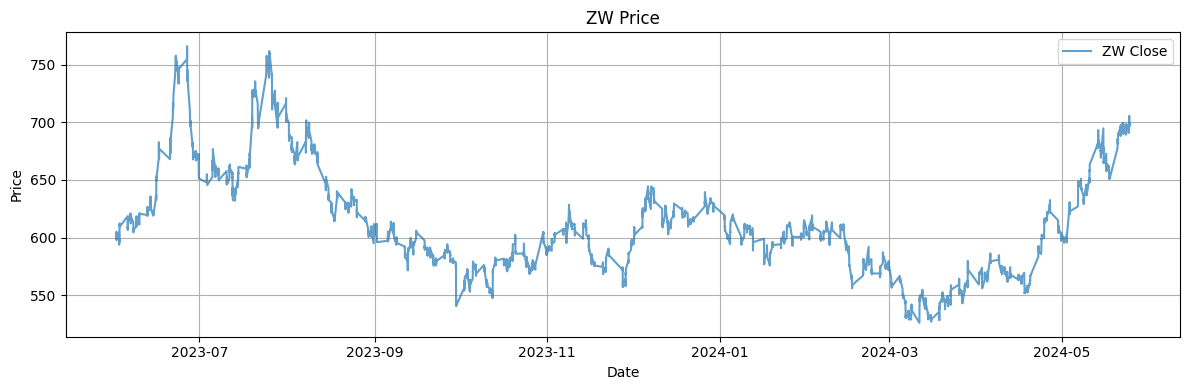

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.plot(futs_df[f'{TARGET_FUT}_Close'], label=f'{TARGET_FUT} Close', alpha=0.7)
plt.title(f'{TARGET_FUT} Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Prepare the Data

In [6]:
import pickle
from tqdm import tqdm

from sklearn.preprocessing import normalize

TEST_SPLIT = 0.8
TRAIN_SIZE = int(len(futs_df) * TEST_SPLIT)
CACHE = True
FUTURES_TMP_FILE = "./tmp/futures.pkl"
os.makedirs("./tmp/", exist_ok=True)

def oversample_mean_reversions(train_agri_ts, window, period=INTERVAL, hurst=HURST):
    samples = []
    for df in tqdm(train_agri_ts, desc="oversample_mean_reversions"):
        bb_df = df.copy()
        results_df = param_search_bbs(bb_df, StockFeatExt.CLOSE, period, initial_window=window * 2, window_min=window // 2, hurst=hurst)
        results_df = results_df[results_df["Metric"] == "Sharpe"]
        bb_df, _ = bollinger_band_backtest(bb_df, StockFeatExt.CLOSE, results_df["Window"].iloc[0], period, std_factor=results_df["Standard_Factor"].iloc[0])

        samples.append(bb_df[train_agri_ts[0].columns].reset_index(drop=True))
    return train_agri_ts + samples

def normalize_and_label_data(ts, meta_label=META_LABEL, cols_to_scale=COLS_TO_SCALE):
    y0 = 0
    y1 = 0
    process_data = []
    for df in tqdm(ts, desc="label_data"):
        df = aug_metalabel_mr(df)
        y0  += (df[meta_label] == 0).sum()
        y1  += (df[meta_label] > 0).sum()

        if cols_to_scale is not None:
            aug_df_scaled = normalize(df[cols_to_scale])
            aug_df_scaled = pd.DataFrame(aug_df_scaled, columns=cols_to_scale)
            df[cols_to_scale] = aug_df_scaled
            df = df.loc[:, ~df.columns.duplicated(keep="first")]

        process_data.append(df)

    total = y0 + y1
    class_weight_0 = total / y0 if y0 != 0 else 0
    class_weight_1 = total / y1 if y1 != 0 else 0
    class_weights = {0: class_weight_0, 1: class_weight_1}

    return process_data, class_weights

with strategy.scope():
    if not os.path.exists(FUTURES_TMP_FILE):
        futs_exog_df = process_exog(MARKET_FUTS, futs_df)
        train_agri_ts, val_agri_ts = process_futures(FUTS, futs_df, futs_exog_df, TRAIN_SIZE, INTERVAL)
        # train_agri_ts = oversample_mean_reversions(train_agri_ts, HALF_LIFE)
        # val_agri_ts = oversample_mean_reversions(val_agri_ts, HALF_LIFE)

        if CACHE:
            with open(FUTURES_TMP_FILE, 'wb') as f:
                pickle.dump((train_agri_ts, val_agri_ts), f)
    else:
        with open(FUTURES_TMP_FILE, 'rb') as f:
            train_agri_ts, val_agri_ts = pickle.load(f)

train_agri_ts, CLASS_WEIGHTS = normalize_and_label_data(train_agri_ts, cols_to_scale=COLS_TO_SCALE)
val_agri_ts, val_weights = normalize_and_label_data(val_agri_ts, cols_to_scale=COLS_TO_SCALE)

print(f"train: {CLASS_WEIGHTS}")
print(f"test: {val_weights}")
np.shape(train_agri_ts)

label_data: 100%|██████████| 16/16 [00:00<00:00, 59.75it/s]

train: {0: 1.038026365869693, 1: 27.2975432211101}
test: {0: 1.0547473469674609, 1: 19.265725288831835}


(16, 3750, 92)

In [7]:
FEATURES = KF_COLS + BB_COLS + MOM_COLS + StockFeatExt.list
FEATURES = StockFeat.list

sample = val_agri_ts[0]
print(sample[META_LABEL].value_counts())

sampled_pattenrs = sample[sample[META_LABEL] > 0]
sampled_pattenrs[FEATURES + [META_LABEL, "Ret"]].tail(10)

mr_label
0    870
1     68
Name: count, dtype: int64


,Open,High,Low,Close,Volume,mr_label,Ret
889,0.122282,0.122415,0.122017,0.122150,0.910353,1,0.000000
890,0.095309,0.095309,0.094947,0.095050,0.942950,1,0.003256
900,0.030252,0.030465,0.030252,0.030465,0.987602,1,0.000000
901,0.062502,0.062502,0.062334,0.062334,0.971473,1,0.000000
902,0.060408,0.060635,0.060408,0.060538,0.970167,1,0.000000
903,0.056749,0.056870,0.056597,0.056627,0.974800,1,0.000000
904,0.067926,0.068218,0.067743,0.068145,0.963959,1,0.000000
905,0.084368,0.084413,0.084051,0.084232,0.949840,1,0.000000
906,0.125601,0.125803,0.125533,0.125533,0.907131,1,0.000000
907,0.089818,0.089867,0.089625,0.089674,0.949825,1,0.004287


In [8]:
WINDOW = 511  # window is the k+k-1xd-1 or the sum i=0..n of 1+sum(receptive feild)x2^i
WINDOW_TMP_PATH = "./tmp/"
# TPU see: https://github.com/tensorflow/tensorflow/issues/41635
BATCH_SIZE = 8  * strategy.num_replicas_in_sync # Default 8
print(f"BATCH_SIZE: {BATCH_SIZE}")

def prepare_windows(data_df, label_df, window_size=WINDOW):
    """
    Prepare windows of features and corresponding labels for classification.
    IMPORTANT: There is no padding, incomplete timewindows are discarded!

    Parameters:
    - data_df: DataFrame containing the features.
    - label_df: DataFrame containing the labels.
    - window_size: The size of the input window.

    Returns:
    - X: Array of input windows.
    - y: Array of corresponding labels.
    """
    X, y = [], []
    for i in range(len(data_df) - window_size):
        input_window = data_df.iloc[i : i + window_size].values
        assert not np.isnan(input_window).any(), "NaN values found in input window"
        X.append(input_window)
        if label_df is not None:
            target_label = label_df.iloc[i + window_size]
            y.append([target_label])
            assert not np.isnan(target_label).any(), "NaN values found in target label"
    return np.array(X), np.array(y)

def prepare_window_with_disjoint_ts(ts_list, window_size=WINDOW):
    """
    Generator function to yield windows of features and corresponding labels from multiple time series.

    Parameters:
    - ts_list: List of DataFrames, each containing a time series.
    - window_size: The size of the input window.

    Yields:
    - features: The input window of features.
    - labels: The corresponding label.
    """
    for data_df in ts_list:
        X, y = prepare_windows(data_df[FEATURES], data_df[META_LABEL], window_size=window_size)
        for features, labels in zip(X, y):
            yield features, labels

def create_windowed_dataset_from_generator(ts_list, window_size=WINDOW, batch_size=BATCH_SIZE):
    """
    Create a TensorFlow dataset from a generator.

    Parameters:
    - ts_list: List of DataFrames, each containing a time series.
    - window_size: The size of the input window.
    - batch_size: The batch size for the dataset.

    Returns:
    - dataset: A TensorFlow dataset.
    """
    dataset = tf.data.Dataset.from_generator(
        lambda: prepare_windows_with_disjoint_ts(ts_list, window_size=window_size),
        output_signature=(
            tf.TensorSpec(shape=(window_size, len(FEATURES)), dtype=tf.float32),
            tf.TensorSpec(shape=(1,), dtype=tf.float32)  # Assuming labels are floats for binary classification
        )
    )
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

def create_dataset_from_generator(ts_list, batch_size):
    def generator(ts_list):
        full_df = pd.concat(ts_list)
        for i, row in full_df.iterrows():
            yield row[FEATURES].values, row[META_LABEL]  # Reshape to match (1,)

    output_signature = (
        tf.TensorSpec(shape=(len(FEATURES),), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.float32)
    )

    dataset = tf.data.Dataset.from_generator(
        lambda: generator(ts_list),
        output_signature=output_signature
    )
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

with strategy.scope():
    train_dataset = create_dataset_from_generator(train_agri_ts, batch_size=BATCH_SIZE)
    val_dataset = create_dataset_from_generator(val_agri_ts, batch_size=BATCH_SIZE)

BATCH_SIZE: 8


In [9]:
# INPUT_SHAPE = (len(FEATURES), ) # The expected shape, where the None shape is BATCH_SIZE

sampled_dataset = val_dataset.shuffle(buffer_size=250).take(1)
for features, labels in train_dataset.take(1):
    INPUT_SHAPE = features.numpy().shape[1:]  # Assuming the shape is (batch_size, len(FEATURES))
    print("Features:", features.numpy())
    print("Labels:", labels.numpy())

print("INPUT_SHAPE:", INPUT_SHAPE)

Features: [[0.05399355 0.05399355 0.05369958 0.05387106 0.9601249 ]
 [0.09476791 0.09489714 0.09416484 0.09446637 0.9228671 ]
 [0.10804174 0.1084357  0.1079925  0.10828797 0.91318417]
 [0.07587954 0.07625894 0.07584505 0.07598301 0.9520813 ]
 [0.13989694 0.14015096 0.13957943 0.13996045 0.86745   ]
 [0.13440841 0.13471334 0.13410349 0.13422546 0.88768095]
 [0.09554233 0.09567262 0.09506463 0.09515148 0.9361412 ]
 [0.19545114 0.19571888 0.19527264 0.1953619  0.75610137]]
Labels: [0. 0. 0. 0. 0. 0. 0. 0.]
INPUT_SHAPE: (5,)


# CNN 

## Architecture

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Add, Multiply, Input, Flatten, Dense, AveragePooling1D, MaxPooling1D, SpatialDropout1D, Activation, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2, l1, l1_l2

MODEL_NAME = "WAVENET"
MAX_DILATION = 8
DILATION_RATE = 1
FILTERS = 32
DROPRATE = 0.4
KERNEL_SIZE = 3
REG_WEIGHTS = 1e-5
CONVOLUTIONS = 10
DENSE_SIZE = 128

def wavenet_block(inputs, layer_id, filters, kernel_size=KERNEL_SIZE,
                  dilation_rate=DILATION_RATE, reg_param=REG_WEIGHTS, dropout_rate=DROPRATE):
    # Filter = is the output, kernel is the input or scope.
    # Dilation expands the receptive field of the kernel.
    conv_f = Conv1D(filters, kernel_size,
                    dilation_rate=dilation_rate,
                    padding='causal',
                    kernel_regularizer=l2(reg_param),
                    name=f'conv_f_{layer_id}')(inputs)
    conv_g = Conv1D(filters, kernel_size,
                    dilation_rate=dilation_rate,
                    padding='causal',
                    kernel_regularizer=l2(reg_param),
                    name=f'conv_g_{layer_id}')(inputs)
    tanh_out = Activation('tanh')(conv_f)
    sigmoid_out = Activation('sigmoid')(conv_g)
    merged = Multiply()([tanh_out, sigmoid_out])
    # merged = SpatialDropout1D(dropout_rate)(merged)

    skip_out = Conv1D(filters, 1, padding='same',
                      kernel_regularizer=l2(reg_param),
                      name=f'skip_{layer_id}')(merged)
    residual_out = Conv1D(filters, 1, padding='same',
                          kernel_regularizer=l2(reg_param),
                          name=f'residual_{layer_id}')(inputs)
    residual_out = Add()([residual_out, skip_out])

    return residual_out, skip_out


def build_wavenet_model(input_shape, filters=FILTERS, kernel_size=KERNEL_SIZE,
                        reg_param=REG_WEIGHTS, dropout_rate=DROPRATE, convolutions=CONVOLUTIONS,
                        max_dilation=MAX_DILATION):
    inputs = Input(shape=input_shape)
    x = inputs
    skip_connections = []

    for i in range(convolutions):
        dilation_rate = min(2 ** i, max_dilation)
        x, skip = wavenet_block(x, layer_id=i,
                                filters=filters,
                                kernel_size=kernel_size,
                                dilation_rate=dilation_rate,
                                reg_param=reg_param,
                                dropout_rate=dropout_rate)
        skip_connections.append(skip)

    x = Add()(skip_connections)
    x = Activation('relu')(x)

    # Downsample the output to coarser frames
    x = AveragePooling1D(pool_size=2)(x)

    x = Conv1D(filters, 1, activation='relu', kernel_regularizer=l2(reg_param), name='post_conv_1')(x)
    x = Conv1D(filters, 1, activation='relu', kernel_regularizer=l2(reg_param), name='post_conv_2')(x)
    x = Flatten()(x)
    x = Dense(DENSE_SIZE, activation='relu', kernel_regularizer=l2(reg_param), name='fc1')(x)
    x = Dropout(dropout_rate, name='fcdo1')(x)
    outputs = Dense(1, activation='sigmoid', kernel_regularizer=l2(reg_param), name='output_dense')(x)

    model = Model(inputs, outputs, name=MODEL_NAME)
    return model

def build_baseline_model(input_shape,
                         filters=FILTERS,
                         kernel_size=KERNEL_SIZE,
                        reg_param=REG_WEIGHTS,
                        dropout_rate=DROPRATE,
                        convolutions=CONVOLUTIONS,
                        max_dilation=MAX_DILATION):
    inputs = Input(shape=input_shape)

    x = Dense(DENSE_SIZE, activation='relu', kernel_regularizer=l1_l2(reg_param))(inputs)
    x = Dropout(dropout_rate)(x)
    x = Dense(DENSE_SIZE, activation='relu', kernel_regularizer=l1_l2(reg_param))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='sigmoid', name='output_dense', kernel_regularizer=l1_l2(reg_param))(x)

    return Model(inputs, outputs, name=f'{MODEL_NAME}_BASELINE')

## Training

In [11]:
import tensorflow as tf

from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import AUC, BinaryAccuracy, TruePositives, Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

import shutil
import json

MODEL_DIR = f"models/{MODEL_NAME}"
IMAGES_DIR = f"images/{MODEL_NAME}/images"
LOG_BASEPATH = f"logs/{MODEL_NAME}/tb"
TARGET_METRIC = "tp"

EPOCHS = 10
PATIENCE_EPOCHS = 2
LEARN_RATE =1e-3
LEARN_RATE_MIN = 1e-5

PURGE = True

if not PURGE:
    # Remove tensorboard logs and other training artefacts for a fresh loop.
    shutil.rmtree(LOG_BASEPATH, ignore_errors=True)
    shutil.rmtree(MODEL_DIR, ignore_errors=True)
    shutil.rmtree(IMAGES_DIR, ignore_errors=True)

def build_cnn(input_shape, train_dataset, test_dataset=None,
              lr=LEARN_RATE,
              lr_min=LEARN_RATE_MIN,
              target_metric=TARGET_METRIC,
              patience=PATIENCE_EPOCHS,
              epochs=EPOCHS):
    model = build_baseline_model(
        input_shape=input_shape,
        filters=FILTERS,
        kernel_size=KERNEL_SIZE,
        reg_param=REG_WEIGHTS,
        dropout_rate=DROPRATE,
        convolutions=CONVOLUTIONS,
    )
    optimizer = Adam(learning_rate=lr)
    loss = BinaryCrossentropy(from_logits=False,
                              reduction='sum_over_batch_size',
                              name='bce')
    model.compile(
        loss=loss,
        optimizer=optimizer,
        metrics=[
            TruePositives(name='tp'),
            Precision(name='p'),
            Recall(name='r'),
            AUC(name='auc'),
            BinaryAccuracy(name='ba')
        ]
    )
    callbacks = [
        EarlyStopping(
            patience=patience,
            monitor=target_metric,
            restore_best_weights=True,
            mode="max" # Watchout for this
        ),
        ReduceLROnPlateau(
            monitor=target_metric,
            factor=0.5,
            patience=2,
            verbose=1,
            min_lr=lr_min,
            mode="max" # Watchout for this
        ),
        TensorBoard(
            log_dir=LOG_BASEPATH,
            histogram_freq=1,
            write_images=True
        )
    ]
    history = model.fit(
        train_dataset,
        validation_data=test_dataset,
        epochs=epochs,
        batch_size=BATCH_SIZE,
        callbacks=callbacks,
        verbose=1
    )
    return model, history

history_dict = None
with strategy.scope():
    if not PURGE and os.path.exists(MODEL_PATH):
        print(f"Loading model from: {MODEL_PATH}")
        model = tf.keras.models.load_model(MODEL_PATH)
        if os.path.exists(f"{MODEL_PATH}\history.json"):
            with open(f"{MODEL_PATH}\history.json", 'r') as f:
                history_dict = json.load(f)
    else:
        print(f"input_shape: {INPUT_SHAPE}")
        model, history = build_cnn(INPUT_SHAPE, train_dataset=train_dataset, test_dataset=val_dataset)
        model.save(MODEL_PATH)
        history_dict = history.history
        # float32 is not directly serializable to JSON
        history_dict = {k: [float(i) for i in v] for k, v in history_dict.items()}
        with open(f"{MODEL_PATH}/history.json", 'w') as f:
            json.dump(history_dict, f)
model.summary()

input_shape: (5,)


2024-06-01 12:28:03.794288: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: Permission denied


Epoch 1/10
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tens

2024-06-01 12:28:06.145647: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fcc405fb9c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-01 12:28:06.145695: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-06-01 12:28:06.152343: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-01 12:28:06.176781: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
I0000 00:00:1717237686.237543  258128 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


   7499/Unknown - 96s 12ms/step - loss: 0.1847 - tp: 0.0000e+00 - p: 0.0000e+00 - r: 0.0000e+00 - auc: 0.7179 - ba: 0.9633

2024-06-01 12:29:39.857395: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17125214550751871146
2024-06-01 12:29:39.857439: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17965578834706006137
2024-06-01 12:29:39.857445: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5513537447554892249
2024-06-01 12:29:39.857449: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 208980870765725139
2024-06-01 12:29:39.857452: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15533045767896516999
2024-06-01 12:29:39.857456: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4513796608533712499
2024-06-01 12:29:39.857459: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv i

7500/7500 [==============================] - 111s 14ms/step - loss: 0.1847 - tp: 0.0000e+00 - p: 0.0000e+00 - r: 0.0000e+00 - auc: 0.7179 - ba: 0.9633 - val_loss: 0.3017 - val_tp: 0.0000e+00 - val_p: 0.0000e+00 - val_r: 0.0000e+00 - val_auc: 0.5000 - val_ba: 0.9481 - lr: 0.0010
Epoch 2/10
7500/7500 [==============================] - 104s 14ms/step - loss: 0.1552 - tp: 0.0000e+00 - p: 0.0000e+00 - r: 0.0000e+00 - auc: 0.7271 - ba: 0.9634 - val_loss: 0.3098 - val_tp: 0.0000e+00 - val_p: 0.0000e+00 - val_r: 0.0000e+00 - val_auc: 0.5000 - val_ba: 0.9481 - lr: 0.0010
Epoch 3/10
7498/7500 [============================>.] - ETA: 0s - loss: 0.1535 - tp: 0.0000e+00 - p: 0.0000e+00 - r: 0.0000e+00 - auc: 0.7253 - ba: 0.9634
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
7500/7500 [==============================] - 118s 16ms/step - loss: 0.1535 - tp: 0.0000e+00 - p: 0.0000e+00 - r: 0.0000e+00 - auc: 0.7253 - ba: 0.9634 - val_loss: 0.3138 - val_tp: 0.0000e+00 - val_p: 

INFO:tensorflow:Assets written to: ./models/assets


Model: "WAVENET_BASELINE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense (Dense)               (None, 128)               768       
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 output_dense (Dense)        (None, 1)                 129       
                                                                 
Total params: 17409 (68.00 KB)
Trainable params: 1

# Visualize History

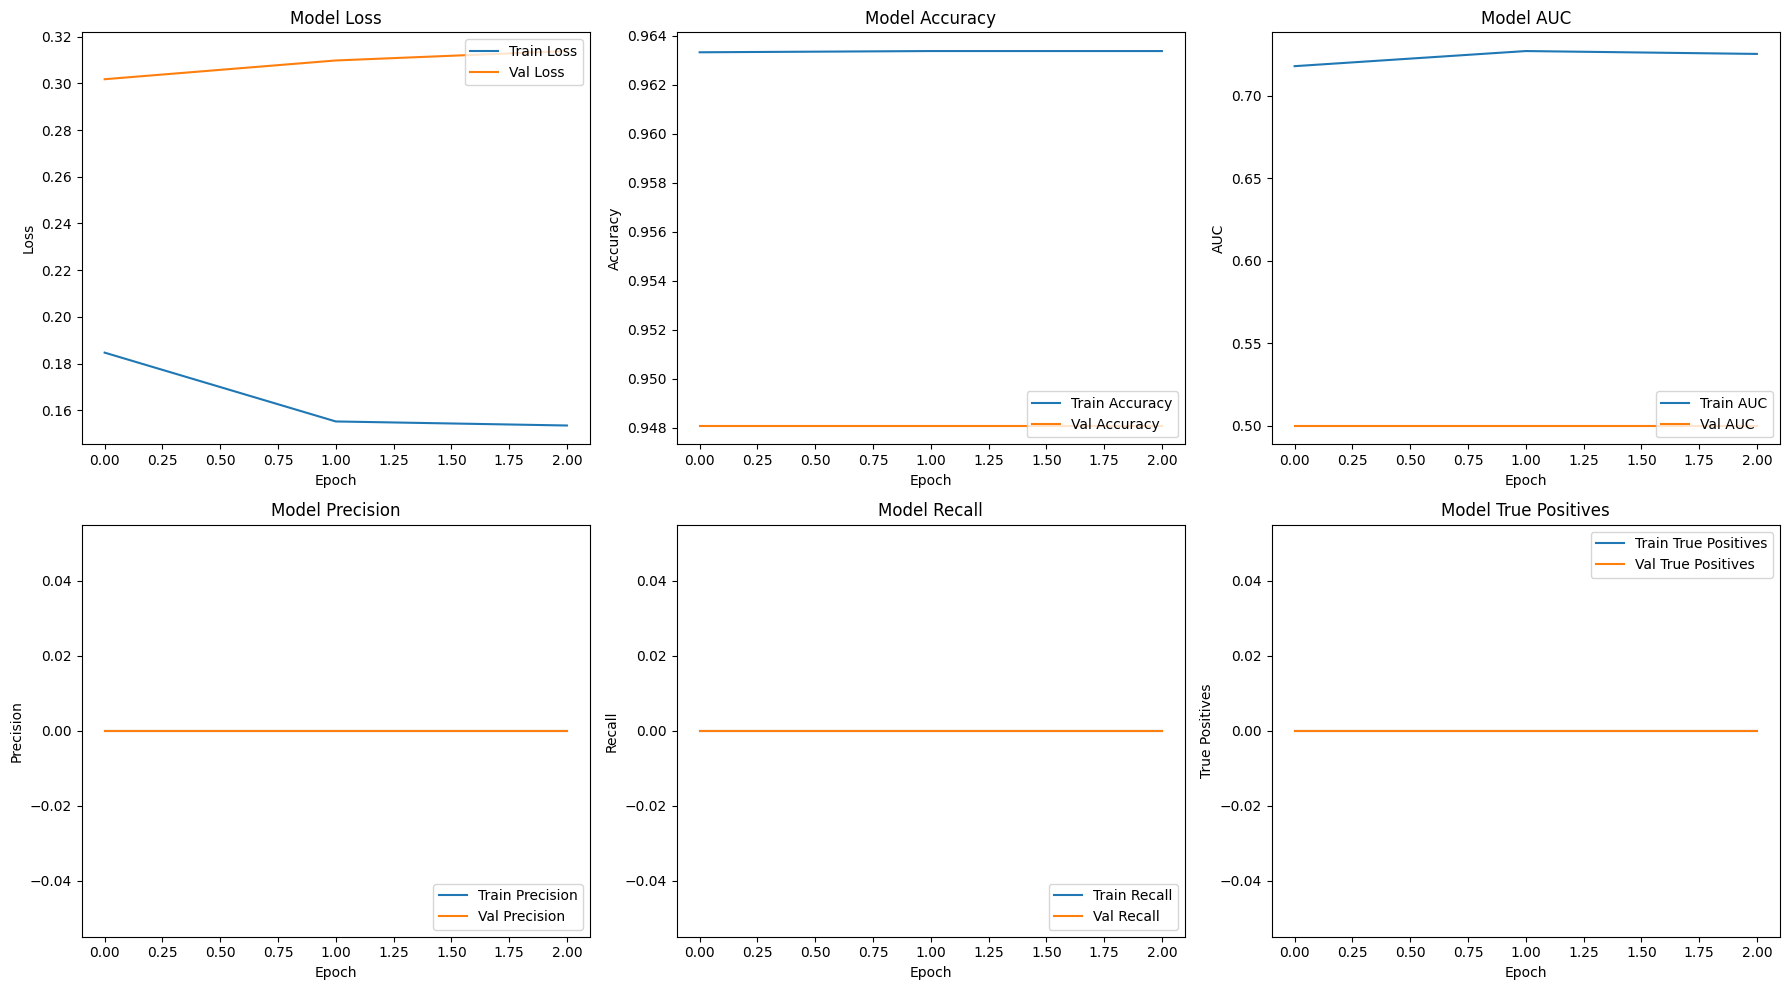

In [12]:
if history_dict is not None:
    plt.figure(figsize=(18, 10))

    # Plotting Loss
    plt.subplot(2, 3, 1)
    plt.plot(history_dict['loss'], label='Train Loss')
    plt.plot(history_dict['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    # Plotting Accuracy
    plt.subplot(2, 3, 2)
    plt.plot(history_dict['ba'], label='Train Accuracy')
    plt.plot(history_dict['val_ba'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    # Plotting AUC
    plt.subplot(2, 3, 3)
    plt.plot(history_dict['auc'], label='Train AUC')
    plt.plot(history_dict['val_auc'], label='Val AUC')
    plt.title('Model AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend(loc='lower right')

    # Plotting Precision
    plt.subplot(2, 3, 4)
    plt.plot(history_dict['p'], label='Train Precision')
    plt.plot(history_dict['val_p'], label='Val Precision')
    plt.title('Model Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend(loc='lower right')

    # Plotting Recall
    plt.subplot(2, 3, 5)
    plt.plot(history_dict['r'], label='Train Recall')
    plt.plot(history_dict['val_r'], label='Val Recall')
    plt.title('Model Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend(loc='lower right')

    # Plotting True Positives
    plt.subplot(2, 3, 6)
    plt.plot(history_dict['tp'], label='Train True Positives')
    plt.plot(history_dict['val_tp'], label='Val True Positives')
    plt.title('Model True Positives')
    plt.xlabel('Epoch')
    plt.ylabel('True Positives')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()


# Explain and Interpret

30/30 [==============================] - 0s 4ms/step


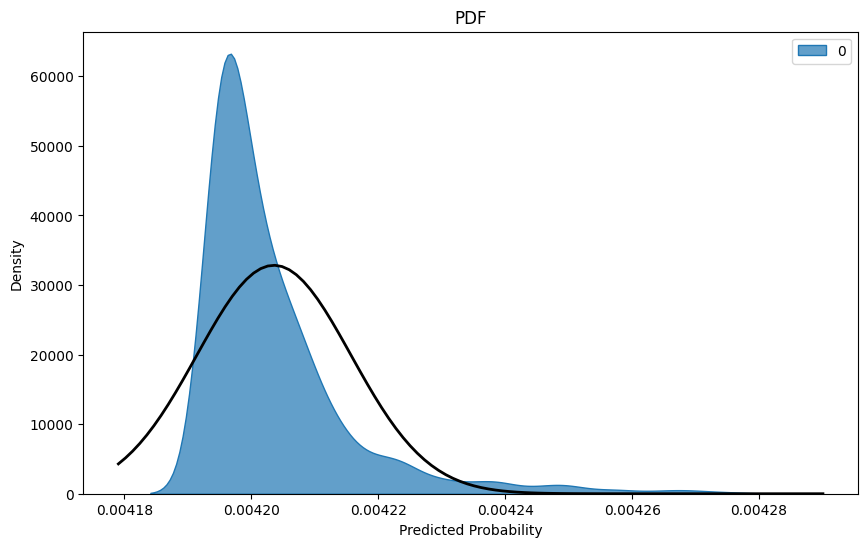

                  0
Accuracy   0.927505
Precision  0.000000
Recall     0.000000
F1b Score  0.860884
ROC AUC    0.272219


In [13]:
import seaborn as sns
from scipy.stats import norm
from sklearn.metrics import accuracy_score, precision_score, recall_score, fbeta_score, roc_auc_score

def print_metrics_and_distribution(model, data, labels):
    ypred_proba = model.predict(data)
    pred = (ypred_proba > 0.5).astype(int)
    metrics = {
        "Accuracy": accuracy_score(labels.flatten(), pred.flatten()),
        "Precision": precision_score(labels.flatten(), pred.flatten()),
        "Recall": recall_score(labels.flatten(), pred.flatten()),
        "F1b Score": fbeta_score(labels.flatten(), pred.flatten(), average="weighted", beta=0.1),
        "ROC AUC": roc_auc_score(labels.flatten(), ypred_proba.flatten(), average='weighted')
    }

    metrics_df = pd.DataFrame.from_dict(metrics, orient='index')

    plt.figure(figsize=(10, 6))
    sns.kdeplot(ypred_proba, color='blue', fill=True, alpha=0.7)

    mu, std = norm.fit(ypred_proba)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)

    plt.title('PDF')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Density')
    plt.show()

    return metrics_df

sample_val = val_agri_ts[0]
metrics_df = print_metrics_and_distribution(model, sample_val[FEATURES].values, sample_val[META_LABEL].values)
print(metrics_df)


30/30 [==============================] - 0s 3ms/step


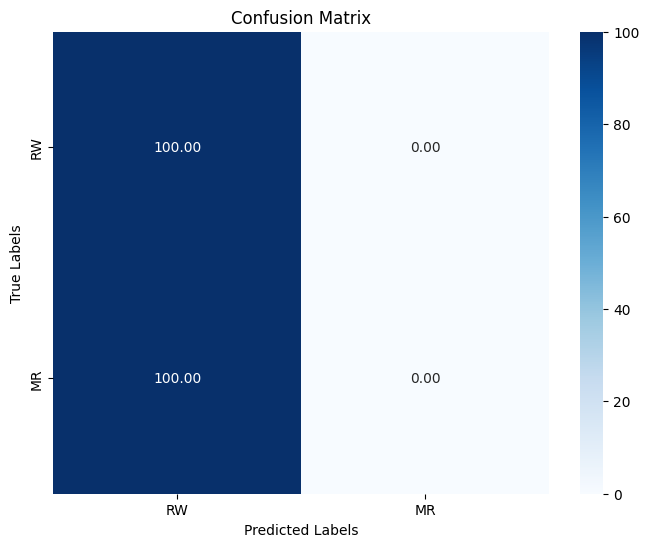

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.math import confusion_matrix

def plot_confusion_matrix(model, data, labels, label_names=['RW', 'MR']):
    ypred_proba = model.predict(data)
    pred = (ypred_proba > 0.5).astype(int)
    cm = confusion_matrix(labels.flatten(), pred)

    plt.figure(figsize=(8, 6))
    df_cm = pd.DataFrame((cm / np.sum(cm, axis=1)[:, None])*100, index=[i for i in label_names], columns=[i for i in label_names])
    cm_plot = sns.heatmap(df_cm, annot=True, fmt=".2f", cmap='Blues', xticklabels=label_names, yticklabels=label_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')

    plt.show()

plot_confusion_matrix(model, sample_val[FEATURES].values, sample_val[META_LABEL].values)

## SHAP

In [15]:
import shap
shap.initjs()

RANDOMIZE_SIZE = 32
SAMPLE_SIZE = 100

train_dataset = create_dataset_from_generator(train_agri_ts, batch_size=BATCH_SIZE)
sampled_dataset = train_dataset.shuffle(buffer_size=RANDOMIZE_SIZE*SAMPLE_SIZE).take(SAMPLE_SIZE)
sampled_dataset = list(sampled_dataset.as_numpy_iterator())

test_dataset = create_dataset_from_generator(train_agri_ts, batch_size=BATCH_SIZE)
sampled_testdataset = test_dataset.shuffle(buffer_size=RANDOMIZE_SIZE*SAMPLE_SIZE).take(SAMPLE_SIZE)
sampled_testdataset = list(sampled_testdataset.as_numpy_iterator())

background_features = np.concatenate([batch[0] for batch in sampled_dataset], axis=0)
background = background_features[np.random.choice(background_features.shape[0], SAMPLE_SIZE, replace=False)]

test_features = np.concatenate([batch[0] for batch in sampled_testdataset], axis=0)
test_labels = np.concatenate([batch[1] for batch in sampled_testdataset], axis=0)

2024-06-01 12:33:50.163953: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:121: Filling up shuffle buffer (this may take a while): 2529 of 3200
2024-06-01 12:33:52.623243: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-06-01 12:34:03.033409: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:129: Filling up shuffle buffer (this may take a while): 2851 of 3200
2024-06-01 12:34:04.273152: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


SHAP values shape: (800, 5)
Test features shape: (800, 5)


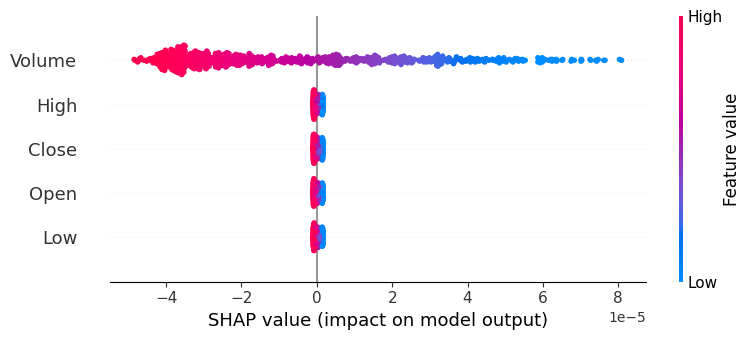

In [16]:
e = shap.DeepExplainer(model, background)

shap_values = e.shap_values(test_features)
if isinstance(shap_values, list):
    shap_values = shap_values[0]
shap_values = np.squeeze(shap_values)

print(f"SHAP values shape: {shap_values.shape}")
print(f"Test features shape: {test_features.shape}")
assert shap_values.shape == test_features.shape
shap.summary_plot(shap_values, test_features, feature_names=FEATURES)

  0%|          | 0/20 [00:00<?, ?it/s]

SHAP values shape: (20, 5, 1)
Misclassified: (20,) out of 20
Explainer expected value: [0.00423711]


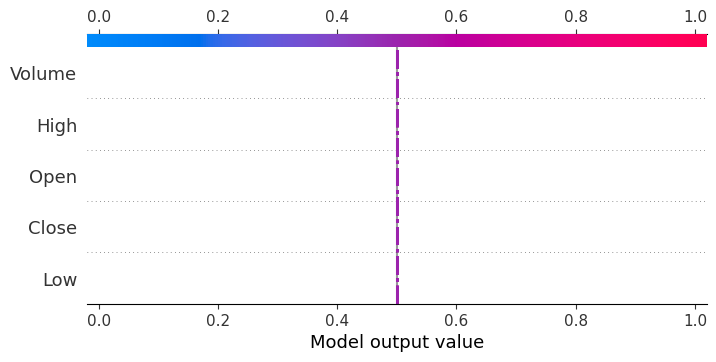

In [17]:
sample_index = 2
e = shap.KernelExplainer(model, background)

select = range(20)
shap_features = test_features[select]
train_features = background_features[select]
shap_values = e.shap_values(shap_features, nsamples=SAMPLE_SIZE)
print(f"SHAP values shape: {shap_values.shape}")

if isinstance(shap_values, list):
    shap_values = shap_values[0: SAMPLE_SIZE]
shap_values = np.squeeze(shap_values)
y_pred = (shap_values.sum(1) + e.expected_value) > 0
misclassified = y_pred != test_labels[select]
print(f"Misclassified: {np.shape(misclassified)} out of {np.shape(y_pred)[0]}")

print(f"Explainer expected value: {e.expected_value}")
shap.decision_plot(e.expected_value, shap_values, train_features, feature_names=FEATURES, link='logit', highlight=misclassified[0])

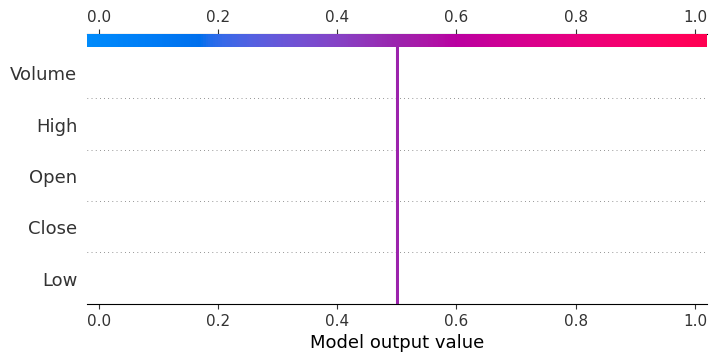

In [18]:
shap.decision_plot(
    e.expected_value,
    shap_values[misclassified],
    train_features[misclassified],
    link="logit",
    highlight=0,
    feature_names=FEATURES
)

In [19]:
shap.force_plot(
    e.expected_value,
    shap_values[misclassified],
    train_features[misclassified],
    link="logit",
    feature_names=FEATURES
)

# Grid Search

In [20]:
from sklearn.model_selection import ParameterGrid, TimeSeriesSplit
from tensorboard.plugins.hparams import api as hp

import json

HP_KERNEL_SIZE = hp.HParam("kernel_size", hp.Discrete([KERNEL_SIZE * 2, KERNEL_SIZE]))
HP_BATCH_SIZE = hp.HParam("batch_size", hp.Discrete([BATCH_SIZE]))
HP_EPOCHS = hp.HParam("epochs", hp.Discrete([EPOCHS]))
HP_DILATION_RATE = hp.HParam("dilation_rate", hp.Discrete([DILATION_RATE]))
HP_DROPOUT_RATE = hp.HParam("dropout_rate", hp.Discrete([DROPRATE, DROPRATE*2]))
HP_REG_WEIGHTS = hp.HParam("reg_weight", hp.Discrete([REG_WEIGHTS, REG_WEIGHTS*2]))
HP_LEARNING_RATE = hp.HParam("learning_rate", hp.Discrete([LEARN_RATE]))
HP_PATIENCE = hp.HParam("patience", hp.Discrete([PATIENCE_EPOCHS]))
HP_HIDDEN_DENSE = hp.HParam("dense_units", hp.Discrete([
    f"{WINDOW}",
    f"{WINDOW*2}_{WINDOW}",
    f"{WINDOW*2}_{WINDOW}_{WINDOW//2}",
    f"{WINDOW*4}_{WINDOW*2}",
]))
HP_FILTERS = hp.HParam("filters", hp.Discrete([FILTERS //2 ,FILTERS, FILTERS * 2]))
HPARAMS = [
    HP_FILTERS,
    HP_KERNEL_SIZE,
    HP_BATCH_SIZE,
    HP_EPOCHS,
    HP_DILATION_RATE,
    HP_DROPOUT_RATE,
    HP_REG_WEIGHTS,
    HP_LEARNING_RATE,
    HP_PATIENCE,
    HP_HIDDEN_DENSE
    ]

def grid_search_build_cnn(input_shape, X, y, Xt=None, yt=None, hparams=HPARAMS, file_name=f"best_params.json", checkpoint_file = f"checkpoint.json"):
    def _decode_arrays(config_str):
        return [int(unit) for unit in config_str.split('_')]

    def _save_best_params(best_params, best_loss, best_metric, other_metrics = None, file_name="best_params.json"):
        os.makedirs(MODEL_DIR, exist_ok=True)
        with open(f"{MODEL_DIR}/{file_name}", "w") as file:
            json.dump({"best_params": best_params, "best_loss": best_loss, "best_metric": best_metric, 'other_metrics': other_metrics}, file)

    def _load_checkpoint(file_name):
        json = None
        try:
            os.makedirs(MODEL_DIR, exist_ok=True)
            with open(f"{MODEL_DIR}/{file_name}", "r") as file:
                json = json.load(file)
        except Exception as e:
            print(f"File {MODEL_DIR}/{file_name} not found or error {e}")
        return json

    def _save_checkpoint(state, file_name):
        os.makedirs(MODEL_DIR, exist_ok=True)
        with open(f"{MODEL_DIR}/{file_name}", "w") as file:
            json.dump(state, file)

    with create_file_writer(f"{LOG_BASEPATH}/hparam_tuning").as_default():
        hp.hparams_config(
            hparams=hparams,
            metrics=[hp.Metric(TARGET_METRIC, display_name=TARGET_METRIC)],
        )

    start_index = 0
    best_loss = np.inf
    best_metric = -np.inf
    best_params = None
    checkpoint = _load_checkpoint(checkpoint_file)
    if checkpoint:
        start_index = checkpoint['next_index']
        best_loss = checkpoint['best_loss']
        best_metric = checkpoint['best_metric']
        best_params = checkpoint['best_params']

    grid = list(ParameterGrid({h.name: h.domain.values for h in hparams}))
    for index, hp_values in enumerate(tqdm(grid[start_index:], desc="Grid Search.."), start=start_index):
        dense_units = _decode_arrays(hp_values["dense_units"])
        filters = _decode_arrays(hp_values["filters"])
        b = hp_values["bias"]
        k = hp_values["kernel_size"]
        d = hp_values["dilation_rate"]
        rw = hp_values["reg_weight"]
        drop = hp_values["dropout_rate"]

        ERROR_ALPHA = hp_values["alpha"]
        ERROR_GAMMA = hp_values["gamma"]
        print(f"Shapes{input_shape}: x{X[0].shape}xg{X[1].shape}y{y.shape}, filters {filters}, dense {dense_units}, k: {k}, d: {d}, rw: {rw}, drop: {drop}, b: {b}, alpha: {ERROR_ALPHA},  gamma: {ERROR_GAMMA}")

        model, history = build_cnn(input_shape, X, y,
                                    Xt=Xt, yt=yt,
                                    filters=filters,
                                    kernel_size=k,
                                    b_cv=True)
        loss = history_dict[f"val_loss"][-1]
        metric = history_dict[f"val_{TARGET_METRIC}"][-1]
        if (metric > best_metric):
            best_history = history
            best_loss = loss
            best_metric = metric
            best_model = model
            best_params = hp_values
            other_metrics = {
                f"{TARGET_METRIC}": history_dict[f"{TARGET_METRIC}"][-1],
                f"v_{TARGET_METRIC}": history_dict[f"val_{TARGET_METRIC}"][-1],
                'ba': history_dict["ba"][-1],
                'v_ba': history_dict["val_ba"][-1],
            }
            _save_best_params(best_params, best_loss, best_metric, other_metrics, file_name)
        checkpoint_state = {
            'next_index': index + 1,
            'best_loss': best_loss,
            'best_metric': best_metric,
            'best_params': best_params
        }
        _save_checkpoint(checkpoint_state, checkpoint_file)
    return best_model, best_history, best_params, best_loss, best_metric

PARAM_SEARCH = False
if PARAM_SEARCH:
    with strategy.scope():
        assert not np.any(pd.isna(X)) and not np.any(np.isnan(X_t))
        print(f"{X.shape}")
        input_shape = (
            WINDOW,
            1 if len(X.shape) < 3 else X.shape[2],
        )

        model, history, best_params, best_loss, best_metric = grid_search_build_cnn(input_shape, X=X, y=y, Xt=X_t, yt=y_t, hparams=HPARAMS)
        print(best_params)
        print(best_metric)

# CV

In [21]:
from sklearn.model_selection import TimeSeriesSplit

CV_MODEL = True
CV_SPLITS = 3

def train_cv_model(X, y, input_shape, n_splits=5, perturb=True, window=WINDOW):
    def _perturb_gaussiannoise(X, noise_level=0.1):
        sigma = noise_level * np.std(X)
        noise = np.random.normal(0, sigma, X.shape)
        return X + noise

    if perturb:
        X = _perturb_gaussiannoise(X)

    results = []
    tscv = TimeSeriesSplit(n_splits=n_splits)
    global metrics_col
    metrics_col = None

    for train_index, test_index in tqdm(tscv.split(X), desc=f"CV Testing for n_splits: {n_splits}"):
        X_train = X.iloc[train_index]
        y_train = y.iloc[train_index]
        X_test = X.iloc[test_index]
        y_test = y.iloc[test_index]

        X_train_windows, y_train_windows = prepare_windows(X_train, y_train, window_size=window)
        X_test_windows, y_test_windows = prepare_windows(X_test, y_test, window_size=window)

        try:
            cv_model, _ = build_cnn(input_shape, X=X_train_windows, y=y_train_windows, Xt=X_test_windows, yt=y_test_windows)

            result = cv_model.evaluate([X_test_windows], y_test_windows, verbose=0)
            results.append(result)

            if metrics_col is None:
                metrics_col = cv_model.metrics
        except Exception as e:
            print(f"CV error on fold with exception: {e}")

    if metrics_col is None:
        raise ValueError("No successful model training; metrics_col is None")

    metrics_names = [metric.name for metric in metrics_col]
    results_df = pd.DataFrame(results, columns=metrics_names)

    return results_df

# results_df = train_cv_model(train_ts_df.drop(columns=[META_LABEL]), train_ts_df[META_LABEL], input_shape)
# results_df